In [1]:
import numpy as np, pandas as pd, os, gc
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt, time
from itertools import repeat
from PIL import Image 

In [2]:
def rle2maskResize(mask_rle):
    #Returns numpy array, 1 - mask, 0 - background
    if mask_rle=='' or pd.isnull(mask_rle):
        return np.zeros((128,800),dtype=np.uint8)
    s = mask_rle.split() #s will be of the format [starting index length starting index length.....]
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])] #starts : list of staring indices and lengths : lengths of each component
    starts -= 1 #convert to zero indexing
    ends = starts + lengths #ending pixels
    img = np.zeros(256*1600, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(1600,256).T[::2,::2]

In [3]:
from keras import backend as K
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate

# COMPETITION METRIC
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1.0)

In [4]:
! pip install segmentation-models
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

     |████████████████████████████████| 50 kB 2.9 MB/s             
Segmentation Models: using `keras` framework.


'tf.keras'

In [5]:
data = pd.read_csv('../input/data-pre/new_data.csv')
idx = int(len(data)*0.9);print()
data = data.iloc[idx:]
data = data.reset_index()
data = data.drop(['index'], axis = 1)
data.fillna('',inplace=True)
data.head(15)

,ImageId,def1,def2,def3,def4,has_defect
0,e5d954e34.jpg,,,268033 128 268289 4864 273154 255 273410 255 2...,,1
1,e5dc1f3a9.jpg,,,,,0
2,e5dd1ea97.jpg,,,228784 4 229035 12 229287 19 229538 27 229791 ...,,1
3,e5dfaf632.jpg,,,94587 7 94831 19 95075 31 95319 43 95563 55 95...,,1
4,e5e0fe470.jpg,,,146572 3 146822 10 147073 15 147323 22 147574 ...,,1
5,e5e22441b.jpg,,,,,0
6,e5ea04944.jpg,,,31233 32 31489 96 31745 160 32001 224 32257 64...,,1
7,e5f1d5a38.jpg,,,238377 69 238634 136 238890 136 239147 135 239...,,1
8,e5f9a5bb9.jpg,,,37358 19 37578 55 37797 92 38017 128 38237 164...,170595 48 170848 54 171101 60 171354 66 171608...,1
9,e6042b9a7.jpg,,,,,0


In [6]:
#from keras.models import load_model
#model = load_model('UNET.h5',custom_objects={'dice_coef':dice_coef})
print(len(data))

1257


In [7]:
from keras.models import load_model
model = load_model('../input/train/UNET.h5',custom_objects={'dice_coef':dice_coef})


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [8]:
preprocess = sm.get_preprocessing('resnet34')

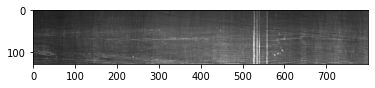

In [9]:
x = Image.open('/kaggle/input/severstal-steel-defect-detection/train_images/' + data['ImageId'].iloc[0]).resize((800,128))
plt.imshow(x) 
plt.show()

In [10]:
#thresholding areas and probabilities
dice_val=0
for i in range(len(data)):
    x = np.array(Image.open('/kaggle/input/severstal-steel-defect-detection/train_images/' + data['ImageId'].iloc[i]).resize((800,128)))
    x = preprocess(x)
    pred = model.predict(np.array( [x,]))[0]
    #threshold on probabilities
    mask1 = np.empty_like(pred[:,:,0])
    mask2 = np.empty_like(pred[:,:,1])
    mask3 = np.empty_like(pred[:,:,2])
    mask4 = np.empty_like(pred[:,:,3])
    mask1 = np.copy(pred[:,:,0])
    mask2 = np.copy(pred[:,:,1])
    mask3 = np.copy(pred[:,:,2])
    mask4 = np.copy(pred[:,:,3])
    mask1 = np.where(mask1>=0.5,1,0)
    mask2 = np.where(mask2>=0.5,1,0)
    mask3 = np.where(mask3>=0.5,1,0)
    mask4 = np.where(mask4>=0.5,1,0)
    #threshold on areas
    area1 = np.sum(mask1)*4 #resizing factor 
    area2 = np.sum(mask2)*4 
    area3 = np.sum(mask3)*4
    area4 = np.sum(mask4)*4
    if area1<300 or area1>13500:
        mask1 = np.zeros((128,800),dtype=np.uint8)
    if area2<500 or area2>9000:
        mask2 = np.zeros((128,800),dtype=np.uint8)
    if area3<900 or area3>140000:
        mask3 = np.zeros((128,800),dtype=np.uint8)
    if area4<2400 or area4>120000:
        mask4 = np.zeros((128,800),dtype=np.uint8)
    actual1 = rle2maskResize(data['def1'].iloc[i])
    actual2 = rle2maskResize(data['def2'].iloc[i])
    actual3 = rle2maskResize(data['def3'].iloc[i])
    actual4 = rle2maskResize(data['def4'].iloc[i])
    dice_val += dice_coef(actual1,mask1)
    dice_val += dice_coef(actual2,mask2)
    dice_val += dice_coef(actual3,mask3)
    dice_val += dice_coef(actual4,mask4)
total = 4*len(data)
dice_val /= total
print(dice_val)
    


2021-12-04 07:44:24.854422: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


0.9222982846890861


In [11]:
#defect1
defect1 = data.loc[data['def1'] != '']
#defect2
defect2 = data.loc[data['def2'] != '']
#defect3
defect3 = data.loc[data['def3'] != '']
#defect4
defect4 = data.loc[data['def4'] != '']
#no defect
no_defect = data.loc[data['has_defect'] == 0]

In [12]:
defect1 = defect1.reset_index()
defect1 = defect1.drop(['index'], axis = 1)
defect1 = defect1.iloc[:3]

defect2 = defect2.reset_index()
defect2 = defect2.drop(['index'], axis = 1)
defect2 = defect2.iloc[:3]

defect3 = defect3.reset_index()
defect3 = defect3.drop(['index'], axis = 1)
defect3 = defect3.iloc[:3]

defect4 = defect4.reset_index()
defect4 = defect4.drop(['index'], axis = 1)
defect4 = defect4.iloc[:3]

no_defect = no_defect.reset_index()
no_defect = no_defect.drop(['index'], axis = 1)
no_defect = no_defect.iloc[:3]


In [13]:
defect1.head()

,ImageId,def1,def2,def3,def4,has_defect
0,e6123fb08.jpg,32246 11 32492 21 32748 21 33004 21 33260 21 3...,,,,1
1,e667de6f9.jpg,200186 7 200429 20 200671 34 200914 47 201163 ...,,,,1
2,e6feea803.jpg,39844 3 40100 7 40356 11 40612 16 40868 20 411...,,256576 23 256832 23 257088 23 257344 23 257600...,,1


In [14]:
defect2.head()

,ImageId,def1,def2,def3,def4,has_defect
0,e6ac69712.jpg,,122640 22 122895 65 123150 108 123405 151 1236...,,,1
1,e77d57652.jpg,,235456 11 235691 32 235927 53 236172 64 236428...,,,1
2,e86b2f3e2.jpg,,382246 13 382478 38 382721 51 382977 52 383233...,,,1


In [15]:
defect3.head()

,ImageId,def1,def2,def3,def4,has_defect
0,e5d954e34.jpg,,,268033 128 268289 4864 273154 255 273410 255 2...,,1
1,e5dd1ea97.jpg,,,228784 4 229035 12 229287 19 229538 27 229791 ...,,1
2,e5dfaf632.jpg,,,94587 7 94831 19 95075 31 95319 43 95563 55 95...,,1


In [16]:
defect4.head()

,ImageId,def1,def2,def3,def4,has_defect
0,e5f9a5bb9.jpg,,,37358 19 37578 55 37797 92 38017 128 38237 164...,170595 48 170848 54 171101 60 171354 66 171608...,1
1,e8814afd2.jpg,,,,333025 4 333274 12 333523 20 333771 28 334020 ...,1
2,e93bfa412.jpg,,,126061 38 126289 114 126531 154 126786 162 127...,42594 3 42845 10 43096 16 43347 23 43598 29 43...,1


In [17]:
no_defect.head()

,ImageId,def1,def2,def3,def4,has_defect
0,e5dc1f3a9.jpg,,,,,0
1,e5e22441b.jpg,,,,,0
2,e6042b9a7.jpg,,,,,0


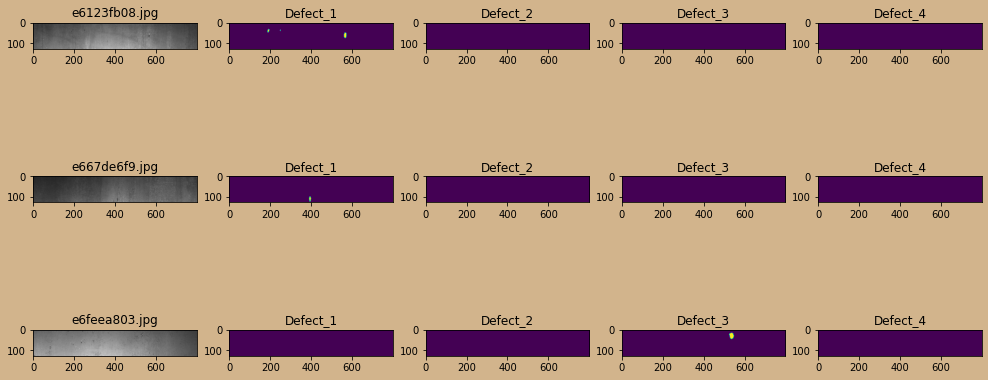

In [18]:
#defect1
fig,ax=plt.subplots(3,5,figsize=(17,8))
for i in range(3):
    x = np.array(Image.open('/kaggle/input/severstal-steel-defect-detection/train_images/' + defect1['ImageId'].iloc[i]).resize((800,128)))
    ax[i,0].imshow(x)
    x = preprocess(x)
    pred = model.predict(np.array( [x,]))[0]
    #threshold on probabilities
    mask1 = np.empty_like(pred[:,:,0])
    mask2 = np.empty_like(pred[:,:,1])
    mask3 = np.empty_like(pred[:,:,2])
    mask4 = np.empty_like(pred[:,:,3])
    mask1 = np.copy(pred[:,:,0])
    mask2 = np.copy(pred[:,:,1])
    mask3 = np.copy(pred[:,:,2])
    mask4 = np.copy(pred[:,:,3])
    mask1 = np.where(mask1>=0.5,1,0)
    mask2 = np.where(mask2>=0.5,1,0)
    mask3 = np.where(mask3>=0.5,1,0)
    mask4 = np.where(mask4>=0.5,1,0)
    #threshold on areas
    area1 = np.sum(mask1)*4 #resizing factor 
    area2 = np.sum(mask2)*4 
    area3 = np.sum(mask3)*4
    area4 = np.sum(mask4)*4
    if area1<300 or area1>13500:
        mask1 = np.zeros((128,800),dtype=np.uint8)
    if area2<500 or area2>9000:
        mask2 = np.zeros((128,800),dtype=np.uint8)
    if area3<900 or area3>140000:
        mask3 = np.zeros((128,800),dtype=np.uint8)
    if area4<2400 or area4>120000:
        mask4 = np.zeros((128,800),dtype=np.uint8)
    ax[i,0].set_title(defect1['ImageId'][i])
    ax[i,1].imshow(mask1)
    ax[i,1].set_title("Defect_1")
    ax[i,2].imshow(mask2)
    ax[i,2].set_title("Defect_2")
    ax[i,3].imshow(mask3)
    ax[i,3].set_title("Defect_3")
    ax[i,4].imshow(mask4)
    ax[i,4].set_title("Defect_4")
fig.set_facecolor("tan")
plt.show()

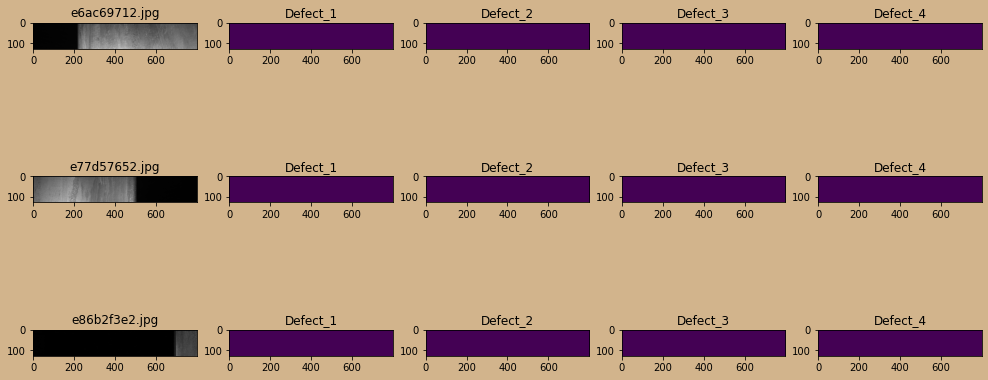

In [19]:
#defect2
fig,ax=plt.subplots(3,5,figsize=(17,8))
for i in range(3):
    x = np.array(Image.open('/kaggle/input/severstal-steel-defect-detection/train_images/' + defect2['ImageId'].iloc[i]).resize((800,128)))
    ax[i,0].imshow(x)
    x = preprocess(x)
    pred = model.predict(np.array( [x,]))[0]
    #threshold on probabilities
    mask1 = np.empty_like(pred[:,:,0])
    mask2 = np.empty_like(pred[:,:,1])
    mask3 = np.empty_like(pred[:,:,2])
    mask4 = np.empty_like(pred[:,:,3])
    mask1 = np.copy(pred[:,:,0])
    mask2 = np.copy(pred[:,:,1])
    mask3 = np.copy(pred[:,:,2])
    mask4 = np.copy(pred[:,:,3])
    mask1 = np.where(mask1>=0.5,1,0)
    mask2 = np.where(mask2>=0.5,1,0)
    mask3 = np.where(mask3>=0.5,1,0)
    mask4 = np.where(mask4>=0.5,1,0)
    #threshold on areas
    area1 = np.sum(mask1)*4 #resizing factor 
    area2 = np.sum(mask2)*4 
    area3 = np.sum(mask3)*4
    area4 = np.sum(mask4)*4
    if area1<300 or area1>13500:
        mask1 = np.zeros((128,800),dtype=np.uint8)
    if area2<500 or area2>9000:
        mask2 = np.zeros((128,800),dtype=np.uint8)
    if area3<900 or area3>140000:
        mask3 = np.zeros((128,800),dtype=np.uint8)
    if area4<2400 or area4>120000:
        mask4 = np.zeros((128,800),dtype=np.uint8)
    ax[i,0].set_title(defect2['ImageId'][i])
    ax[i,1].imshow(mask1)
    ax[i,1].set_title("Defect_1")
    ax[i,2].imshow(mask2)
    ax[i,2].set_title("Defect_2")
    ax[i,3].imshow(mask3)
    ax[i,3].set_title("Defect_3")
    ax[i,4].imshow(mask4)
    ax[i,4].set_title("Defect_4")
fig.set_facecolor("tan")
plt.show()

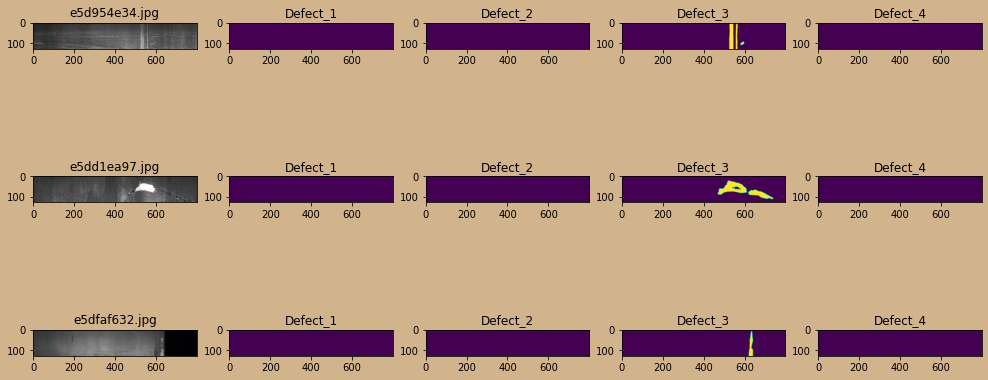

In [20]:
#defect3
fig,ax=plt.subplots(3,5,figsize=(17,8))
for i in range(3):
    x = np.array(Image.open('/kaggle/input/severstal-steel-defect-detection/train_images/' + defect3['ImageId'].iloc[i]).resize((800,128)))
    ax[i,0].imshow(x)
    x = preprocess(x)
    pred = model.predict(np.array( [x,]))[0]
    #threshold on probabilities
    mask1 = np.empty_like(pred[:,:,0])
    mask2 = np.empty_like(pred[:,:,1])
    mask3 = np.empty_like(pred[:,:,2])
    mask4 = np.empty_like(pred[:,:,3])
    mask1 = np.copy(pred[:,:,0])
    mask2 = np.copy(pred[:,:,1])
    mask3 = np.copy(pred[:,:,2])
    mask4 = np.copy(pred[:,:,3])
    mask1 = np.where(mask1>=0.5,1,0)
    mask2 = np.where(mask2>=0.5,1,0)
    mask3 = np.where(mask3>=0.5,1,0)
    mask4 = np.where(mask4>=0.5,1,0)
    #threshold on areas
    area1 = np.sum(mask1)*4 #resizing factor 
    area2 = np.sum(mask2)*4 
    area3 = np.sum(mask3)*4
    area4 = np.sum(mask4)*4
    if area1<300 or area1>13500:
        mask1 = np.zeros((128,800),dtype=np.uint8)
    if area2<500 or area2>9000:
        mask2 = np.zeros((128,800),dtype=np.uint8)
    if area3<900 or area3>140000:
        mask3 = np.zeros((128,800),dtype=np.uint8)
    if area4<2400 or area4>120000:
        mask4 = np.zeros((128,800),dtype=np.uint8)
    ax[i,0].set_title(defect3['ImageId'][i])
    ax[i,1].imshow(mask1)
    ax[i,1].set_title("Defect_1")
    ax[i,2].imshow(mask2)
    ax[i,2].set_title("Defect_2")
    ax[i,3].imshow(mask3)
    ax[i,3].set_title("Defect_3")
    ax[i,4].imshow(mask4)
    ax[i,4].set_title("Defect_4")
fig.set_facecolor("tan")
plt.show()

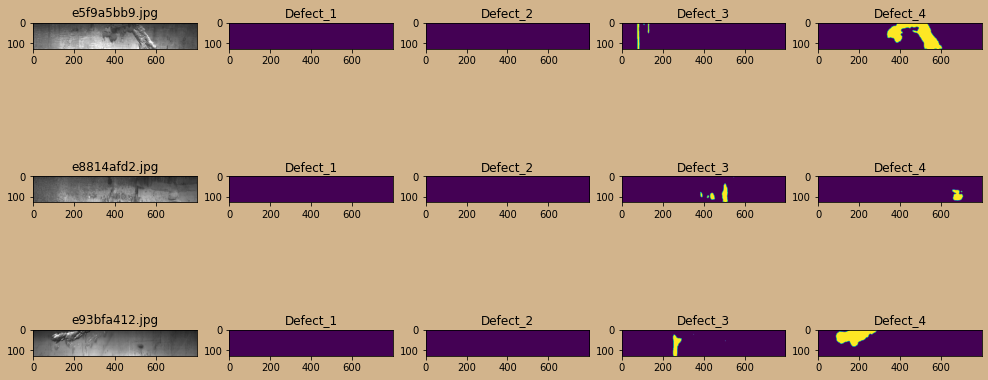

In [21]:
#defect1
fig,ax=plt.subplots(3,5,figsize=(17,8))
for i in range(3):
    x = np.array(Image.open('/kaggle/input/severstal-steel-defect-detection/train_images/' + defect4['ImageId'].iloc[i]).resize((800,128)))
    ax[i,0].imshow(x)
    x = preprocess(x)
    pred = model.predict(np.array( [x,]))[0]
    #threshold on probabilities
    mask1 = np.empty_like(pred[:,:,0])
    mask2 = np.empty_like(pred[:,:,1])
    mask3 = np.empty_like(pred[:,:,2])
    mask4 = np.empty_like(pred[:,:,3])
    mask1 = np.copy(pred[:,:,0])
    mask2 = np.copy(pred[:,:,1])
    mask3 = np.copy(pred[:,:,2])
    mask4 = np.copy(pred[:,:,3])
    mask1 = np.where(mask1>=0.5,1,0)
    mask2 = np.where(mask2>=0.5,1,0)
    mask3 = np.where(mask3>=0.5,1,0)
    mask4 = np.where(mask4>=0.5,1,0)
    #threshold on areas
    area1 = np.sum(mask1)*4 #resizing factor 
    area2 = np.sum(mask2)*4 
    area3 = np.sum(mask3)*4
    area4 = np.sum(mask4)*4
    if area1<300 or area1>13500:
        mask1 = np.zeros((128,800),dtype=np.uint8)
    if area2<500 or area2>9000:
        mask2 = np.zeros((128,800),dtype=np.uint8)
    if area3<900 or area3>140000:
        mask3 = np.zeros((128,800),dtype=np.uint8)
    if area4<2400 or area4>120000:
        mask4 = np.zeros((128,800),dtype=np.uint8)
    ax[i,0].set_title(defect4['ImageId'][i])
    ax[i,1].imshow(mask1)
    ax[i,1].set_title("Defect_1")
    ax[i,2].imshow(mask2)
    ax[i,2].set_title("Defect_2")
    ax[i,3].imshow(mask3)
    ax[i,3].set_title("Defect_3")
    ax[i,4].imshow(mask4)
    ax[i,4].set_title("Defect_4")
fig.set_facecolor("tan")
plt.show()

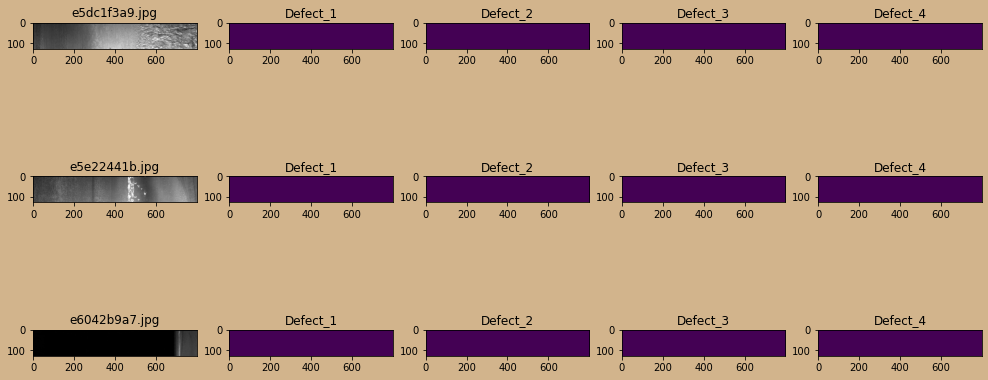

In [22]:
#defect1
fig,ax=plt.subplots(3,5,figsize=(17,8))
for i in range(3):
    x = np.array(Image.open('/kaggle/input/severstal-steel-defect-detection/train_images/' + no_defect['ImageId'].iloc[i]).resize((800,128)))
    ax[i,0].imshow(x)
    x = preprocess(x)
    pred = model.predict(np.array( [x,]))[0]
    #threshold on probabilities
    mask1 = np.empty_like(pred[:,:,0])
    mask2 = np.empty_like(pred[:,:,1])
    mask3 = np.empty_like(pred[:,:,2])
    mask4 = np.empty_like(pred[:,:,3])
    mask1 = np.copy(pred[:,:,0])
    mask2 = np.copy(pred[:,:,1])
    mask3 = np.copy(pred[:,:,2])
    mask4 = np.copy(pred[:,:,3])
    mask1 = np.where(mask1>=0.5,1,0)
    mask2 = np.where(mask2>=0.5,1,0)
    mask3 = np.where(mask3>=0.5,1,0)
    mask4 = np.where(mask4>=0.5,1,0)
    #threshold on areas
    area1 = np.sum(mask1)*4 #resizing factor 
    area2 = np.sum(mask2)*4 
    area3 = np.sum(mask3)*4
    area4 = np.sum(mask4)*4
    if area1<300 or area1>13500:
        mask1 = np.zeros((128,800),dtype=np.uint8)
    if area2<500 or area2>9000:
        mask2 = np.zeros((128,800),dtype=np.uint8)
    if area3<900 or area3>140000:
        mask3 = np.zeros((128,800),dtype=np.uint8)
    if area4<2400 or area4>120000:
        mask4 = np.zeros((128,800),dtype=np.uint8)
    ax[i,0].set_title(no_defect['ImageId'][i])
    ax[i,1].imshow(mask1)
    ax[i,1].set_title("Defect_1")
    ax[i,2].imshow(mask2)
    ax[i,2].set_title("Defect_2")
    ax[i,3].imshow(mask3)
    ax[i,3].set_title("Defect_3")
    ax[i,4].imshow(mask4)
    ax[i,4].set_title("Defect_4")
fig.set_facecolor("tan")
plt.show()